In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ab-test-data/AB_Test_Results.csv


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 분석 내용

### 1. 문제정의
----------------
- 사이트가 수익을 증가시키기 위해 A/B 테스트의 변형조건을 사용해야 하는지에 대한 조사

### 2. 기대효과
--------------
- 올바른 비즈니스적 판단을 위한 기준 제공

### 3. 해결방법
------------------------
-  A/B 테스트 결과를 효과적으로 분석하고 조직에 대한 실행 가능한 권장 사항을 제공

# Data loading and cleaning

In [3]:
path = '/kaggle/input/ab-test-data/AB_Test_Results.csv'
df = pd.read_csv(path)

In [4]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [5]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [6]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [18]:
# 열 인덱스를 단일 레벨로 간소화
def drop_col_level(df) -> pd.DataFrame:
    df.columns = df.columns.droplevel()

    return df

In [19]:
# 사용자별로 그룹화
customer_data = (
    pd.read_csv("../input/ab-test-data/AB_Test_Results.csv")
    .groupby("USER_ID").agg({
        "VARIANT_NAME":[
            ("variant", lambda df: df.iloc[0]),
            ("n_groups", "nunique"),
            ("n_visits", "count"),
        ],
        "REVENUE": [
            ("total_revenue", "sum"),
            ("has_purchased", lambda series: np.sum(series) > 0)
        ]
    })
    .pipe(drop_col_level)
        # 두 가지 조건에 모두 속한 사용자를 제외합니다.
    .query("n_groups == 1")
    .drop(columns=["n_groups"])
    
    # outliers 제거
    .query("total_revenue < 50")
)

,variant,n_visits,total_revenue,has_purchased
USER_ID,,,,
2,control,3,0.0,False
4,variant,1,0.0,False
5,variant,1,0.0,False
6,variant,1,0.0,False
9,variant,1,0.0,False


In [20]:
customer_data

,variant,n_visits,total_revenue,has_purchased
USER_ID,,,,
2,control,3,0.0,False
4,variant,1,0.0,False
5,variant,1,0.0,False
6,variant,1,0.0,False
9,variant,1,0.0,False
...,...,...,...,...
9990,variant,1,0.0,False
9992,control,1,0.0,False
9993,control,1,0.0,False


## Bootstrap Analysis


In [21]:
# 난수 생성기와 실험 횟수를 설정
rng = np.random.default_rng(seed=42)
N_trials = 10000

고객 당 수익은 전반적으로 변형 조건에서 0.04 통화 단위 감소했습니다. </br>
이는 34.8%의 감소를 나타냅니다.







In [22]:
avg_control = customer_data.query("variant == 'control'").total_revenue.mean()
avg_variant = customer_data.query("variant == 'variant'").total_revenue.mean()

absolute_change = avg_variant - avg_control
relative_change = (avg_variant - avg_control) / avg_control

print(f"Revenue change: {absolute_change:.2f} ({relative_change:.1%})")

Revenue change: -0.04 (-34.8%)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

Text(0.5, 1.0, 'Revenue change M=-0.04 CI=(-0.10,0.02)')

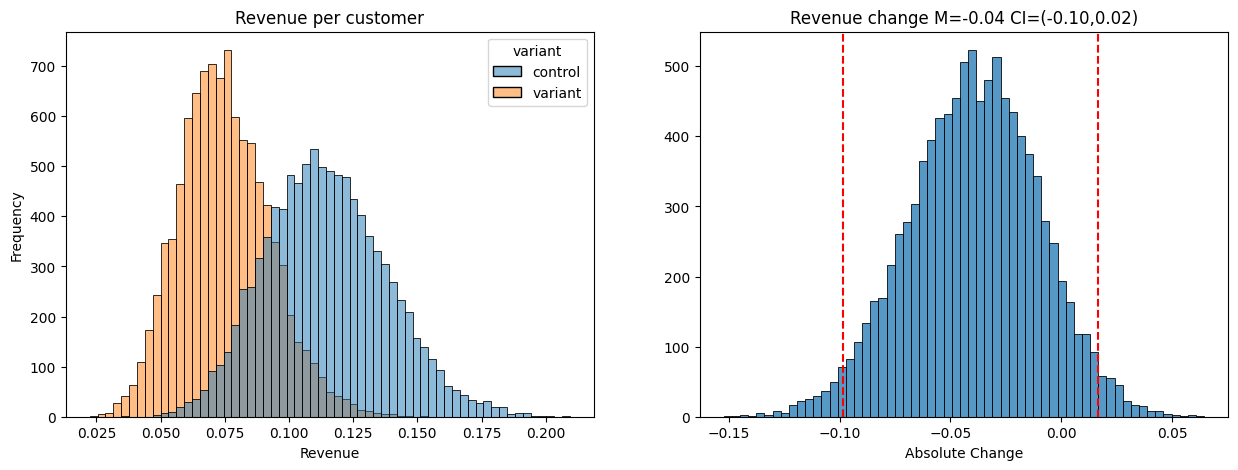

In [23]:
n_total = len(customer_data)
n_variant = len(customer_data.query("variant == 'variant'"))

revenue_boostrap = (
    pd.DataFrame({
        "control": np.mean(rng.choice(customer_data.query("variant == 'control'").total_revenue, (N_trials, n_total - n_variant)), axis=-1),
        "variant": np.mean(rng.choice(customer_data.query("variant == 'variant'").total_revenue, (N_trials, n_variant)), axis=-1),
    })
    .assign(difference=lambda df: df.variant - df.control)
)

# 95% 신뢰 구간을 계산합니다.
ci_lower = np.percentile(revenue_boostrap.difference, 2.5)
ci_upper = np.percentile(revenue_boostrap.difference, 97.5)
avg_change = np.mean(revenue_boostrap.difference)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=revenue_boostrap.drop(columns="difference").melt(value_name="total_revenue", var_name="variant"), x="total_revenue", hue="variant", ax=ax[0])
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Revenue")
ax[0].set_title("Revenue per customer")

sns.histplot(data=revenue_boostrap, x="difference", ax=ax[1])
ax[1].axvline(ci_lower, linestyle="--", color="red")
ax[1].axvline(ci_upper, linestyle="--", color="red")
ax[1].set_ylabel("")
ax[1].set_xlabel("Absolute Change")
ax[1].set_title(f"Revenue change M={avg_change:.2f} CI=({ci_lower:.2f},{ci_upper:.2f})")


다음으로, 이 결과를 유의하다고 인정하기 위해 선택해야 할 신뢰 구간의 폭을 계산할 수 있습니다.</br>
즉, 부트스트랩을 위한 p-값을 계산합니다.</br>

(참고: 이 구현은 p-값을 과대평가합니다. 또한, 효과가 음수라고 가정합니다.)

In [24]:
counts, cutoffs = np.histogram(revenue_boostrap.difference, 100)
zero_idx = np.argmax(cutoffs > 0)
percentiles = np.cumsum(counts) / sum(counts)

cutoff_percentile = percentiles[zero_idx-1]
ci_size = 2 * (cutoff_percentile - .5)
p_value = 1 - ci_size

print(f"We would choose a {ci_size:.2%} confidence interval and obtain a p-value of {p_value:.4}")

We would choose a 84.92% confidence interval and obtain a p-value of 0.1508


## 참여도 (미유의적으로 유의하지 않음)
고객은 사이트를 약간 더 자주 방문합니다(0.01회, 0.5% 증가). </br>
그러나 이는 아마도 잘못된 발견일 가능성이 높습니다.

In [25]:
avg_control = customer_data.query("variant == 'control'").n_visits.mean()
avg_variant = customer_data.query("variant == 'variant'").n_visits.mean()

absolute_change = avg_variant - avg_control
relative_change = (avg_variant - avg_control) / avg_control

print(f"Engagement change: {absolute_change:.2f} ({relative_change:.1%})")

Engagement change: 0.01 (0.5%)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

Text(0.5, 1.0, 'Engagement Change M=0.01 CI=(-0.02,0.04)')

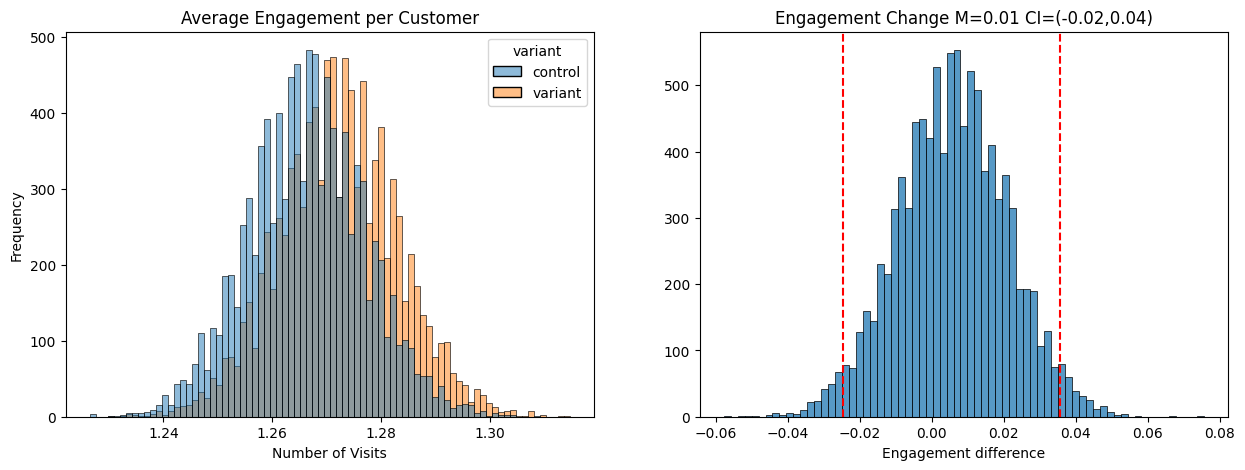

In [26]:
n_total = len(customer_data)
n_variant = len(customer_data.query("variant == 'variant'"))

engagement_bootstrap = (
    pd.DataFrame({
        "control": np.mean(rng.choice(customer_data.query("variant == 'control'").n_visits, (N_trials, n_total - n_variant)), axis=-1),
        "variant": np.mean(rng.choice(customer_data.query("variant == 'variant'").n_visits, (N_trials, n_variant)), axis=-1),
    })
    .assign(difference=lambda df: df.variant - df.control)
)

ci_lower = np.percentile(engagement_bootstrap.difference, 2.5)
ci_upper = np.percentile(engagement_bootstrap.difference, 97.5)
avg_change = np.mean(engagement_bootstrap.difference)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=engagement_bootstrap.drop(columns="difference").melt(value_name="n_visits", var_name="variant"), x="n_visits", hue="variant", ax=ax[0])
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Number of Visits")
ax[0].set_title("Average Engagement per Customer")

sns.histplot(data=engagement_bootstrap, x="difference", ax=ax[1])
ax[1].axvline(ci_lower, linestyle="--", color="red")
ax[1].axvline(ci_upper, linestyle="--", color="red")
ax[1].set_ylabel("")
ax[1].set_xlabel("Engagement difference")
ax[1].set_title(f"Engagement Change M={avg_change:.2f} CI=({ci_lower:.2f},{ci_upper:.2f})")

### 구매 결정 (미유의적으로 유의하지 않음)
고객은 변형 조건에서 구매를 0.46% 덜 확률적으로 하게 됩니다.</br> 이는 대조 조건과 비교하여 상대적으로 20.9% 감소한 것입니다.

In [27]:
avg_control = customer_data.query("variant == 'control'").has_purchased.mean() * 100
avg_variant = customer_data.query("variant == 'variant'").has_purchased.mean() * 100

absolute_change = avg_variant - avg_control
relative_change = (avg_variant - avg_control) / avg_control

print(f"Purchase Frequency change: {absolute_change:.2f} ({relative_change:.1%})")

Purchase Frequency change: -0.46 (-20.9%)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

Text(0.5, 1.0, 'Purchase Frequency Change M=-0.46% CI=(-1.26,0.33)')

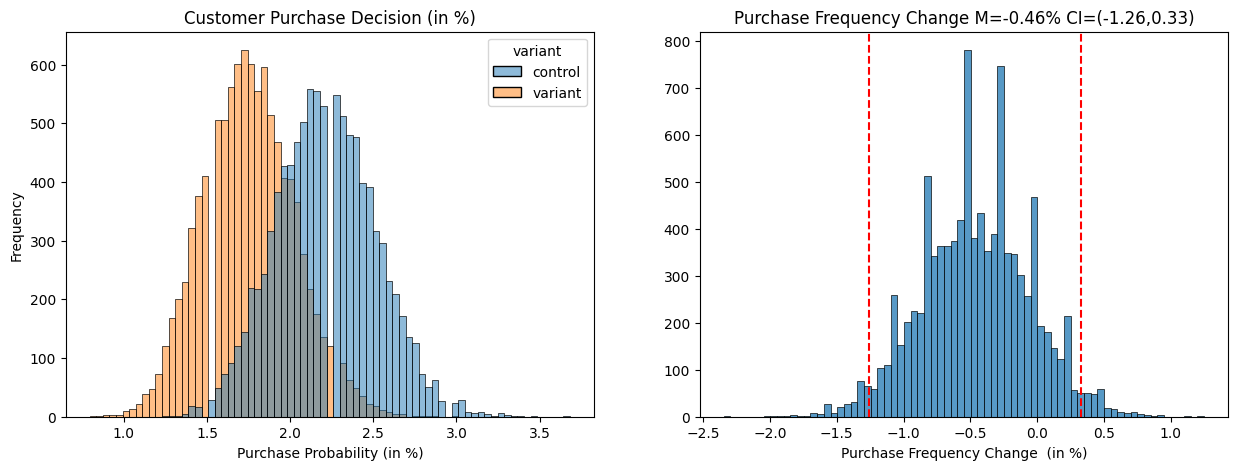

In [28]:
n_total = len(customer_data)
n_variant = len(customer_data.query("variant == 'variant'"))

purchase_decision_bootstrap = (
    pd.DataFrame({
        "control": np.mean(rng.choice(customer_data.query("variant == 'control'").has_purchased * 100, (N_trials, n_total - n_variant)), axis=-1),
        "variant": np.mean(rng.choice(customer_data.query("variant == 'variant'").has_purchased * 100, (N_trials, n_variant)), axis=-1),
    })
    .assign(difference=lambda df: df.variant - df.control)
)

ci_lower = np.percentile(purchase_decision_bootstrap.difference, 2.5)
ci_upper = np.percentile(purchase_decision_bootstrap.difference, 97.5)
avg_change = np.mean(purchase_decision_bootstrap.difference)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=purchase_decision_bootstrap.drop(columns="difference").melt(value_name="has_purchased", var_name="variant"), x="has_purchased", hue="variant", ax=ax[0])
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Purchase Probability (in %)")
ax[0].set_title("Customer Purchase Decision (in %)")

sns.histplot(data=purchase_decision_bootstrap, x="difference", ax=ax[1])
ax[1].axvline(ci_lower, linestyle="--", color="red")
ax[1].axvline(ci_upper, linestyle="--", color="red")
ax[1].set_ylabel("")
ax[1].set_xlabel("Purchase Frequency Change  (in %)")
ax[1].set_title(f"Purchase Frequency Change M={avg_change:.2f}% CI=({ci_lower:.2f},{ci_upper:.2f})")

### 결제 시 장바구니 크기 (미유의적으로 유의하지 않음)
구매를 결정한 고객들은 변형 조건에서 약 0.91 통화 단위로 지출이 줄어듭니다(17.6% 감소).

In [29]:
avg_control = customer_data.query("total_revenue > 0").query("variant == 'control'").total_revenue.mean()
avg_variant = customer_data.query("total_revenue > 0").query("variant == 'variant'").total_revenue.mean()

absolute_change = avg_variant - avg_control
relative_change = (avg_variant - avg_control) / avg_control

print(f"Basket size change: {absolute_change:.2f} ({relative_change:.1%})")

Basket size change: -0.91 (-17.6%)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

Text(0.5, 1.0, 'Revenue change M=-0.93 CI=(-3.10,1.29)')

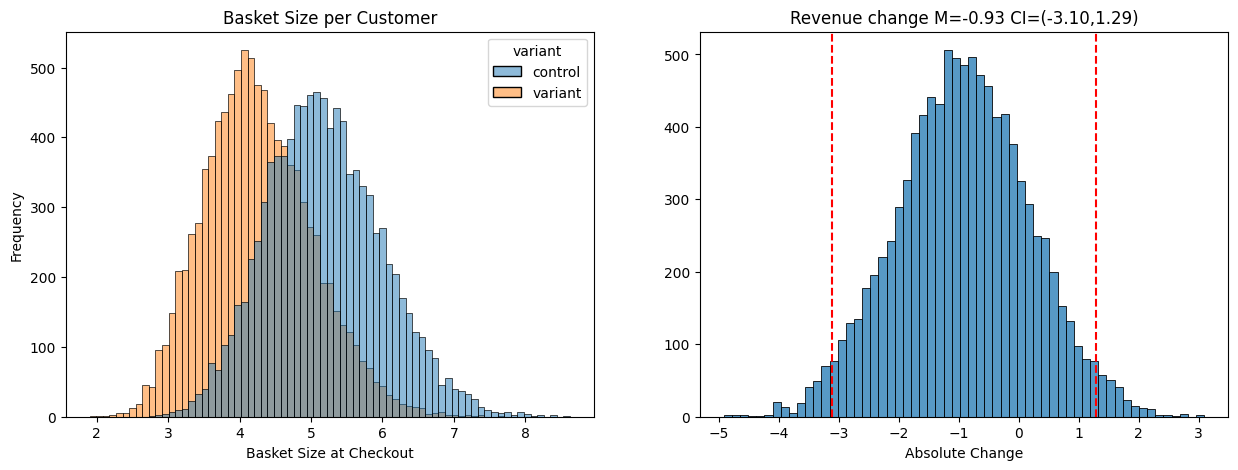

In [30]:
paying_customers = customer_data.query("total_revenue > 0")

n_total = len(paying_customers)
n_variant = len(paying_customers.query("variant == 'variant'"))

basket_size_bootstrap = (
    pd.DataFrame({
        "control": np.mean(rng.choice(paying_customers.query("variant == 'control'").total_revenue, (N_trials, n_total - n_variant)), axis=-1),
        "variant": np.mean(rng.choice(paying_customers.query("variant == 'variant'").total_revenue, (N_trials, n_variant)), axis=-1),
    })
    .assign(difference=lambda df: df.variant - df.control)
)

ci_lower = np.percentile(basket_size_bootstrap.difference, 2.5)
ci_upper = np.percentile(basket_size_bootstrap.difference, 97.5)
avg_change = basket_size_bootstrap.difference.mean()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=basket_size_bootstrap.drop(columns="difference").melt(value_name="total_revenue", var_name="variant"), x="total_revenue", hue="variant", ax=ax[0])
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Basket Size at Checkout")
ax[0].set_title("Basket Size per Customer")

sns.histplot(data=basket_size_bootstrap, x="difference", ax=ax[1])
ax[1].axvline(ci_lower, linestyle="--", color="red")
ax[1].axvline(ci_upper, linestyle="--", color="red")
ax[1].set_ylabel("")
ax[1].set_xlabel("Absolute Change")
ax[1].set_title(f"Revenue change M={avg_change:.2f} CI=({ci_lower:.2f},{ci_upper:.2f})")

# A/B 테스트 결과
이 프로젝트는 웹사이트의 수익을 높이기 위해 A/B 테스트의 변형 조건을 적용해야 할지 여부를 조사하는 것이었습니다. 분석 결과를 통해 변형 조건을 채택하면 안 된다는 결론을 내렸습니다. 고객 당 수익이 34.8% 감소했기 때문입니다. 이러한 감소의 주된 이유로는 (1) 방문자의 구매 결정이 상대적으로 20.9% 줄어든 것과 (2) 결제 시 평균 장바구니 크기가 0.91 통화 단위 줄어든 것이 있습니다.

하지만 이러한 통계적 결과는 모두 유의하지 않습니다. 따라서 위의 결론이 특이한 샘플에 의해 영향을 받을 수 있다는 가능성이 약 15% 정도 있습니다. 따라서 더욱 확고한 결론을 얻기 위해서는 실험 기간을 연장하고 더 많은 데이터를 수집해야 할 것입니다. 그러나 이러한 조치는 전반적인 결론을 변경하지 않을 것입니다. 왜냐하면 확장된 실험 결과는 (a) 변형이 기준을 초과한 수익을 가져오지 않거나 (b) 변형이 기준에 비해 수익을 (유의하게) 줄이는 것 중 하나일 것입니다.